### Amazon Sentiment Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import lxmls.readers.sentiment_reader as srs
from lxmls.deep_learning.utils import AmazonData
corpus = srs.SentimentCorpus("books")
data = AmazonData(corpus=corpus)

### Exercise 2.2 Implement Backpropagation for an MLP in Numpy and train it
Instantiate the feed-forward model class and optimization parameters. This models follows the architecture described in Algorithm 7.

In [3]:
# Model
geometry = [corpus.nr_features, 20, 2]
activation_functions = ['sigmoid', 'softmax']

# Optimization
learning_rate = 0.05
num_epochs = 10
batch_size = 30
#for testing
#batch_size = 1


In [4]:
from lxmls.deep_learning.numpy_models.mlp import NumpyMLP
model = NumpyMLP(
    geometry=geometry,
    activation_functions=activation_functions,
    learning_rate=learning_rate
)

#### Milestone 1:
Open the code for this model. This is located in 

    lxmls/deep_learning/numpy_models/mlp.py
    
Implement the method `backpropagation()` in the class `NumpyMLP` using Backpropagation recursion that we just saw.

As a first step focus on getting the gradients of each layer, one at a time. Use the code below to plot the loss values for the study weight and perturbed versions. 

In [5]:
from lxmls.deep_learning.mlp import get_mlp_parameter_handlers, get_mlp_loss_range

# Get functions to get and set values of a particular weight of the model
get_parameter, set_parameter = get_mlp_parameter_handlers(
    layer_index=1,
    is_bias=False,
    row=0, 
    column=0
)

# Get batch of data
batch = data.batches('train', batch_size=batch_size)[0]

# Get loss and weight value
current_loss = model.cross_entropy_loss(batch['input'], batch['output'])
current_weight = get_parameter(model.parameters)

# Get range of values of the weight and loss around current parameters values
weight_range, loss_range = get_mlp_loss_range(model, get_parameter, set_parameter, batch)

Once you have implemented at least the gradient of the last layer. You can start checking if the values match

In [6]:
# Get the gradient value for that weight
ref_gradients = model.ref_backpropagation(batch['input'], batch['output'])
gradients = model.backpropagation(batch['input'], batch['output'])
#check the shapes to ensure i am returning the output in the same size as expected by the overall code.
print(gradients[0][0].shape)
print(gradients[0][1].shape)
print(gradients[1][0].shape)
print(gradients[1][1].shape)
print('------------')
print(ref_gradients[0][0].shape)
print(ref_gradients[0][1].shape)
print(ref_gradients[1][0].shape)
print(ref_gradients[1][1].shape)

current_gradient = get_parameter(gradients)
ref_current_gradient = get_parameter(ref_gradients)


(20, 13989)
(1, 20)
(2, 20)
(1, 2)
------------
(20, 13989)
(1, 20)
(2, 20)
(1, 2)


Now you can plot the values of the loss around a given parameters value versus the gradient. If you have implemented this correctly the gradient should be tangent to the loss at the current weight value, see Figure 3.5. Once you have completed the exercise, you should be able to plot also the gradients of the other layers. Take into account that the gradients for the first layer will only be non zero for the indices of words present in the batch. You can locate this using.

In [7]:
# Use this to know the non-zero values of the input (that have non-zero gradient)
batch['input'][0].nonzero()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131], dtype=int64),)

Copy the following code for plotting

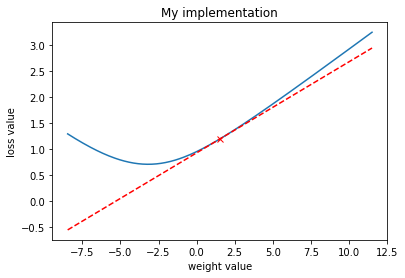

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot empirical
plt.plot(weight_range, loss_range)
plt.plot(current_weight, current_loss, 'xr')
plt.title('My implementation')
plt.ylabel('loss value')
plt.xlabel('weight value')
# Plot real
h = plt.plot(
    weight_range,
    current_gradient*(weight_range - current_weight) + current_loss, 
    'r--'
)
plt.show()

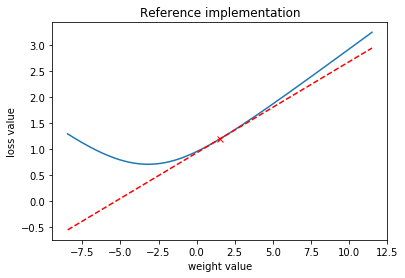

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt2
# Plot empirical
plt2.plot(weight_range, loss_range)
plt2.plot(current_weight, current_loss, 'xr')
plt2.title('Reference implementation')
plt2.ylabel('loss value')
plt2.xlabel('weight value')
# Plot real
h = plt2.plot(
    weight_range,
    ref_current_gradient*(weight_range - current_weight) + current_loss, 
    'r--'
)
plt2.show()

#### Milestone 2:
After you have ensured that your Backpropagation algorithm is correct, you can train a model with the data we have.

In [10]:
# Get batch iterators for train and test
train_batches = data.batches('train', batch_size=batch_size)
test_set = data.batches('test', batch_size=None)[0]

# Epoch loop
for epoch in range(num_epochs):

    # Batch loop
    for batch in train_batches:
        model.update(input=batch['input'], output=batch['output'])

    # Prediction for this epoch
    hat_y = model.predict(input=test_set['input'])

    # Evaluation
    accuracy = 100*np.mean(hat_y == test_set['output'])

    # Inform user
    print("Epoch %d: accuracy %2.2f %%" % (epoch+1, accuracy))

Epoch 1: accuracy 60.25 %
Epoch 2: accuracy 67.50 %
Epoch 3: accuracy 74.50 %
Epoch 4: accuracy 76.25 %
Epoch 5: accuracy 78.00 %
Epoch 6: accuracy 78.75 %
Epoch 7: accuracy 79.00 %
Epoch 8: accuracy 79.75 %
Epoch 9: accuracy 80.00 %
Epoch 10: accuracy 80.25 %
